# Script to perform the background removal on qsd2_w2 images

In [2]:
# Import necessary libraries
import imageio
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening, binary_closing, gaussian_filter, median_filter, morphological_gradient, binary_erosion, binary_dilation
from scipy import ndimage


In [3]:
# Path to the images
image_folder = "../Data/Week2/qsd2_w2/qsd2_w1/"  # Update this path as necessary
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
mask_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()
mask_files.sort()

In [4]:
def rgb2lab(image):
    """Convert an RGB image to LAB color space using the formula."""
    # Normalize RGB values to [0, 1]
    image = image / 255.0
    # Convert RGB to XYZ
    mask = image > 0.04045
    image[mask] = ((image[mask] + 0.055) / 1.055) ** 2.4
    image[~mask] = image[~mask] / 12.92
    image = image * 100

    # Observer = 2°, Illuminant = D65
    x = image[:, :, 0] * 0.4124564 + image[:, :, 1] * 0.3575761 + image[:, :, 2] * 0.1804375
    y = image[:, :, 0] * 0.2126729 + image[:, :, 1] * 0.7151522 + image[:, :, 2] * 0.0721750
    z = image[:, :, 0] * 0.0193339 + image[:, :, 1] * 0.1191920 + image[:, :, 2] * 0.9503041

    # Convert XYZ to LAB
    x /= 95.047
    y /= 100.000
    z /= 108.883

    mask = x > 0.008856
    x[mask] = x[mask] ** (1/3)
    x[~mask] = (x[~mask] * 7.787) + (16 / 116)

    mask = y > 0.008856
    y[mask] = y[mask] ** (1/3)
    y[~mask] = (y[~mask] * 7.787) + (16 / 116)

    mask = z > 0.008856
    z[mask] = z[mask] ** (1/3)
    z[~mask] = (z[~mask] * 7.787) + (16 / 116)

    l = (116 * y) - 16
    a = 500 * (x - y)
    b = 200 * (y - z)

    lab_image = np.stack([l, a, b], axis=-1)
    return lab_image

In [5]:
def rgb2gray(image):
    """Convert an RGB image to grayscale."""
    # Normalize RGB values to [0, 1]
    image = image / 255.0

    # Apply the standard RGB-to-grayscale formula:
    # Luminance = 0.2989 * R + 0.5870 * G + 0.1140 * B
    gray_image = 0.2989 * image[..., 0] + 0.5870 * image[..., 1] + 0.1140 * image[..., 2]

    # Ensure values are in [0, 255] range
    gray_image = np.clip(gray_image * 255, 0, 255).astype(np.uint8)
    
    return gray_image


In [6]:
# Function to remove background

def remove_background(image_path, border_width=10, open_se=7, close_se=7, tau_percentile=95, filter=None):
    """
    0. (Optional) Preprocess with a Gaussian or median filter to reduce noise.
    1. Convert BGR→Lab; take X = [a, b]**.
    2. Border sample → estimate μ, Σ (use shrinkage if Σ ill-conditioned).
    3. Compute dm for all pixels; τ = 95th percentile of border distances.
    4. Mask = (dm > τ).
    5. Morphology: opening (disk r=2–3) → closing (r=2–3) → largest CC.
    6. Keep largest CC and fill holes.
    7. Apply mask to the image.

    Returns original image, binary mask, and image with background removed.
    """
    # Read the image
    im = imageio.imread(image_path)

    # 0. Preprocess with a Gaussian filter to reduce noise (optional)
    if filter=='gaussian':
        im = gaussian_filter(im, sigma=1)
    elif filter=='median':
        im = median_filter(im, size=3)
    # else no filtering
    
    # 1. Convert RGB to Lab color space and extract a* and b* channels
    # TODO: use HS (of HSV) instead of Lab
    lab_image = rgb2lab(im)
    a = lab_image[:, :, 1]
    b = lab_image[:, :, 2]
    
    # 2. Sample border pixels to estimate mean and covariance
    H, W = a.shape
    bw = min(border_width, H//2, W//2)  # guard for tiny images

    border_mask = np.zeros((H, W), dtype=bool)
    border_mask[:bw, :] = True
    border_mask[-bw:, :] = True
    border_mask[:, :bw] = True
    border_mask[:, -bw:] = True

    ab = np.stack([a, b], axis=-1)          # (H, W, 2)
    border_samples = ab[border_mask]        # (N, 2)

    mu = np.mean(border_samples, axis=0) # (2,)
    sigma = np.cov(border_samples, rowvar=False) # (2, 2)
    eps = 1e-5 # to avoid singular matrix in case of numerical issues
    sigma += np.eye(sigma.shape[0]) * eps
    sigma_inv = np.linalg.pinv(sigma) # safer than np.linalg.inv in case of singular matrix

    # 3. Compute Mahalanobis distance for all pixels
    ab_flat = ab.reshape(-1, 2)  # (H*W, 2)
    diff = ab_flat - mu
    dm = np.sqrt(np.sum(diff @ sigma_inv * diff, axis=1)).reshape(a.shape)
    
    # tau = np.percentile(dm, tau_percentile)
    tau = np.percentile(dm[border_mask], tau_percentile)
    
    # 4. Initial mask
    mask = dm > tau

    # 5. Morphological operations
    mask = binary_opening(mask, structure=np.ones((open_se, open_se))).astype(mask.dtype)
    mask = binary_closing(mask, structure=np.ones((close_se, close_se))).astype(mask.dtype)

    # 6. Keep only the largest connected component and remove small spurious detections.
    labeled_mask, num_features = ndimage.label(mask)
    if num_features > 0:
        sizes = ndimage.sum(mask, labeled_mask, range(1, num_features + 1))
        largest_cc = (labeled_mask == (np.argmax(sizes) + 1))
        mask = largest_cc

    # fill holes
    mask = ndimage.binary_fill_holes(mask).astype(mask.dtype)
    

    # Apply mask to the image
    output_image = im * mask[:, :, np.newaxis]

    return im, mask, output_image



In [ ]:
def remove_background_morphological_gradient(image_path, filter=None):
    # Read the image
    im = imageio.imread(image_path)

    # 0. Preprocess with a Gaussian filter to reduce noise (optional)
    if filter=='gaussian':
        im = gaussian_filter(im, sigma=1)
    elif filter=='median':
        im = median_filter(im, size=3)
    # else no filtering
    
    # 1. Convert from RGB to grayscale
    im_gray = rgb2gray(im)  # Converts to 0-1 range grayscale image

    # 2. Compute morphological gradient to see gradient changes
    grad = morphological_gradient(im_gray, structure=np.ones((7, 7)))

    # 3. Thresholding to highlight the edges
    n = 0.15 # hyperparameter
    threshold = np.max(grad) * n 
    grad_bin = grad > threshold

    # 4. Opening and closing to erase small objects
    mask = binary_opening(grad_bin, structure=np.ones((12, 12)))
    mask = binary_closing(mask, structure=np.ones((7, 7)))
    
    # Testing purpose
    plt.imshow(mask, cmap="gray")
    plt.show

    # 5. Find the rectangular shape
    # Find the coordinates of the edges in the binary image
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)

    # Identify the boundaries (min and max) of the rectangular shape
    row_min, row_max = np.min(np.where(rows)[0]), np.max(np.where(rows)[0])
    col_min, col_max = np.min(np.where(cols)[0]), np.max(np.where(cols)[0])

    # Create a mask around the rectangle
    mask = np.zeros_like(grad_bin, dtype=np.uint8)
    mask[row_min:row_max+1, col_min:col_max+1] = 1
    
    # Apply mask to the image
    output_image = im * mask[:, :, np.newaxis]

    return im, mask, output_image

C:\Users\pml03\AppData\Local\Temp\ipykernel_15544\2348874942.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(image_path)


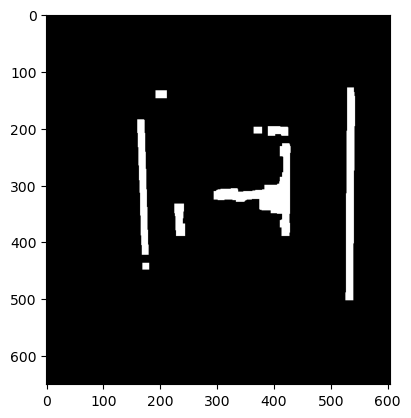

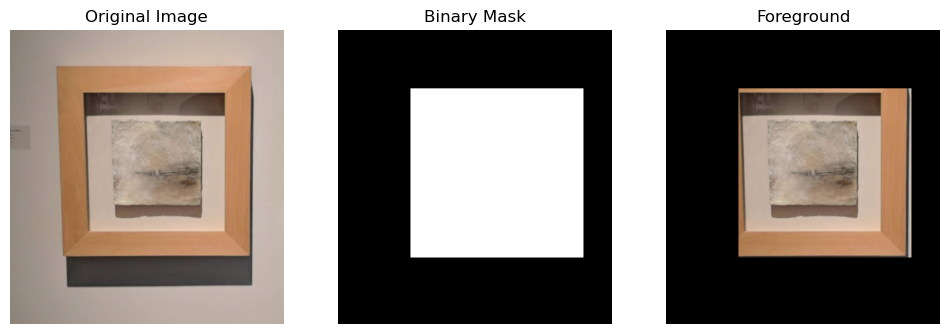

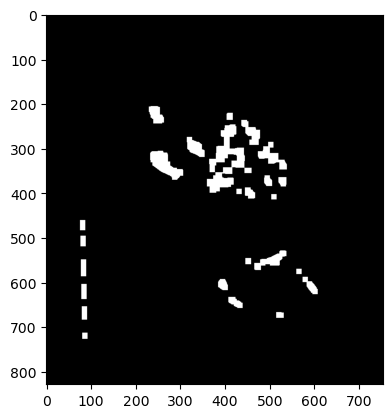

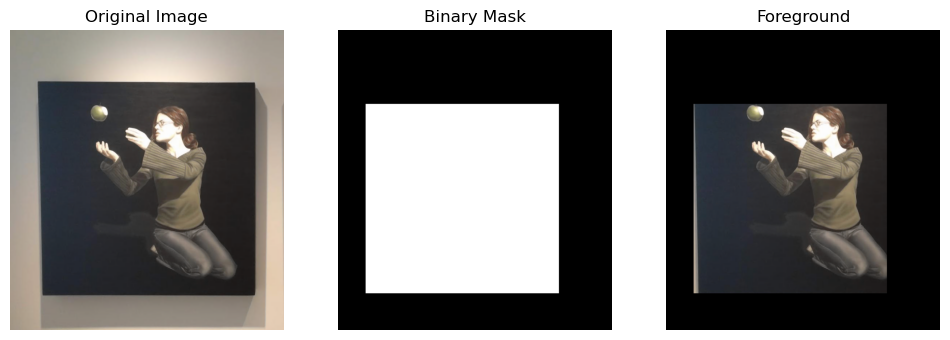

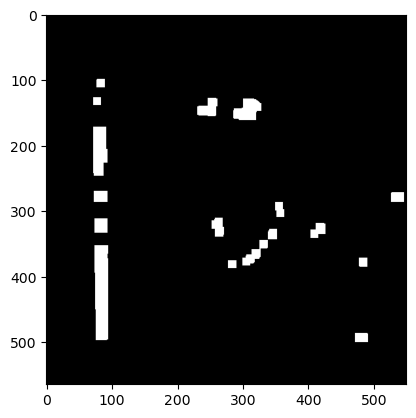

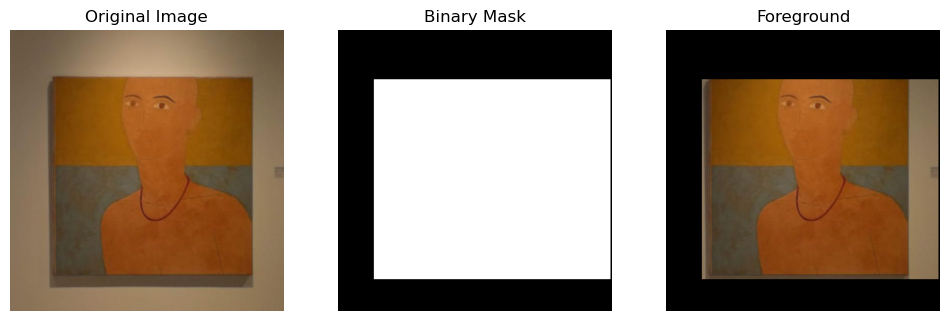

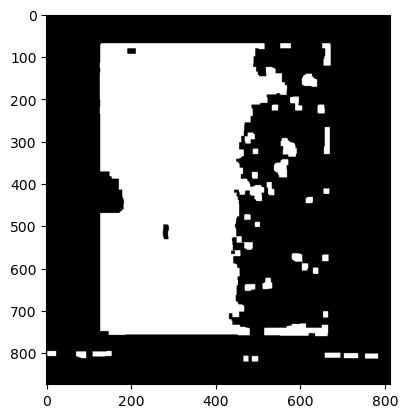

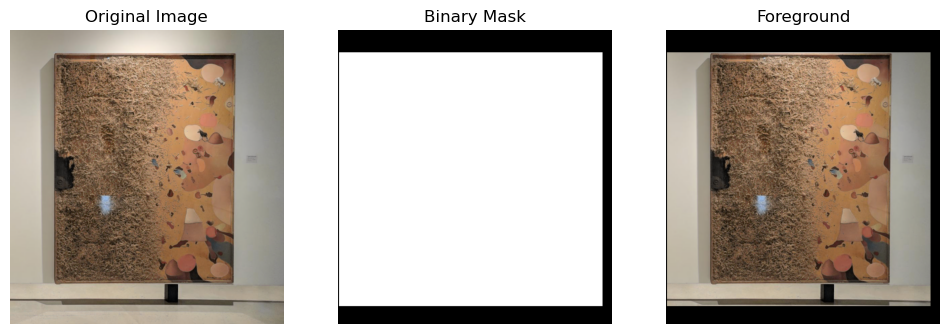

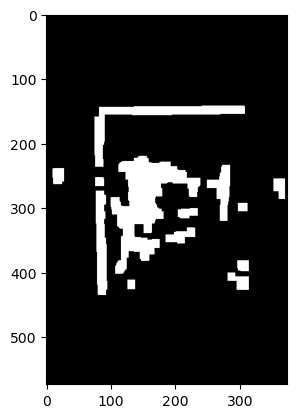

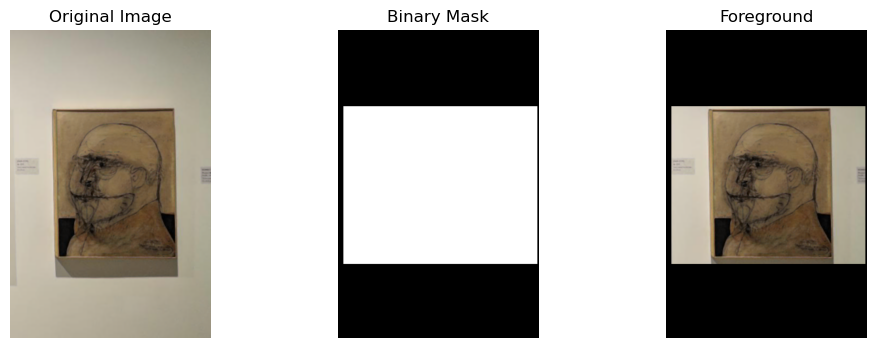

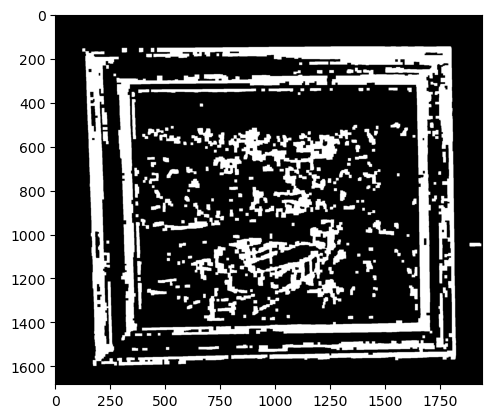

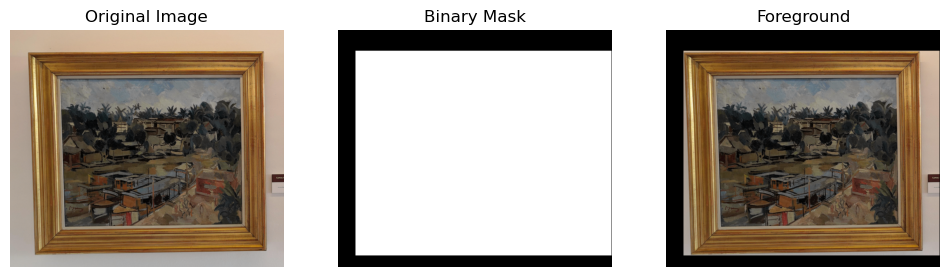

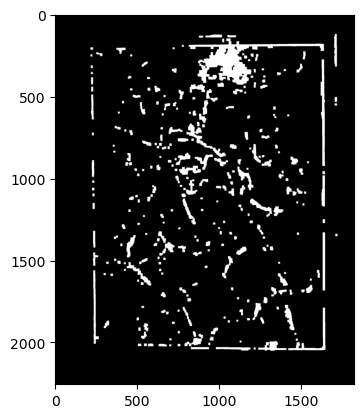

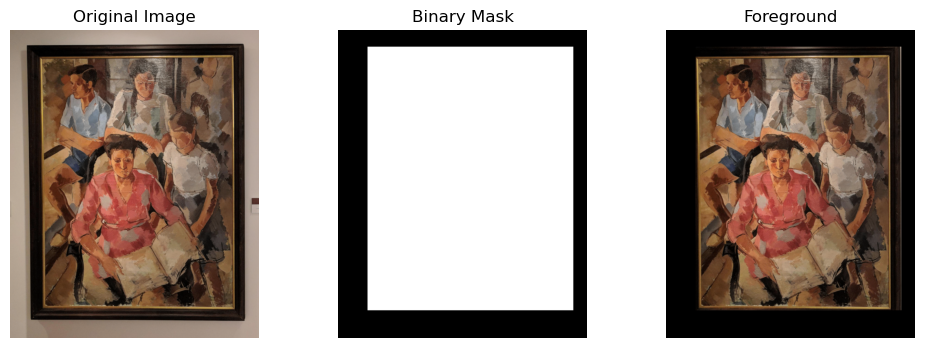

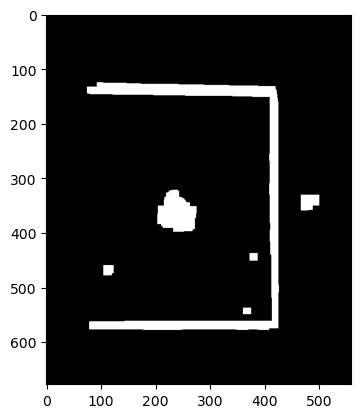

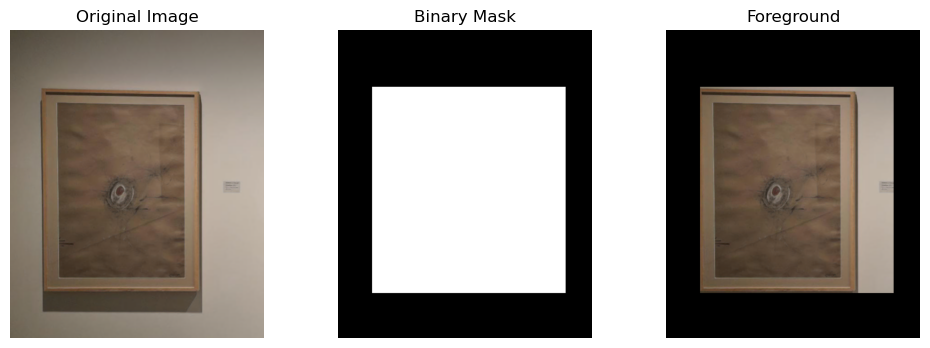

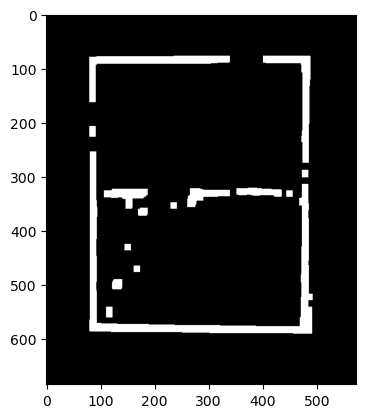

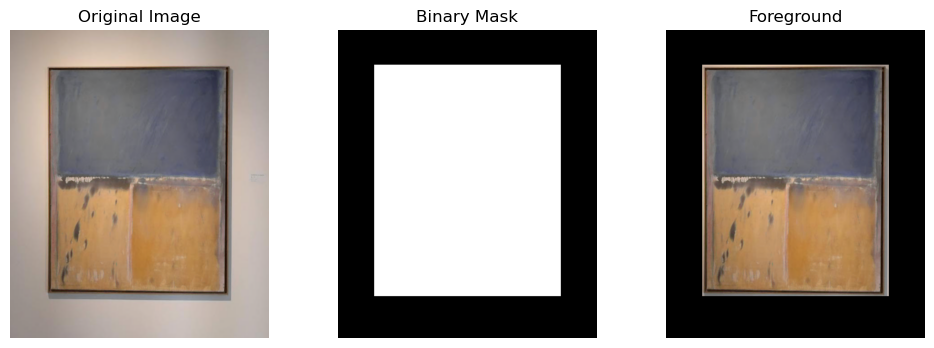

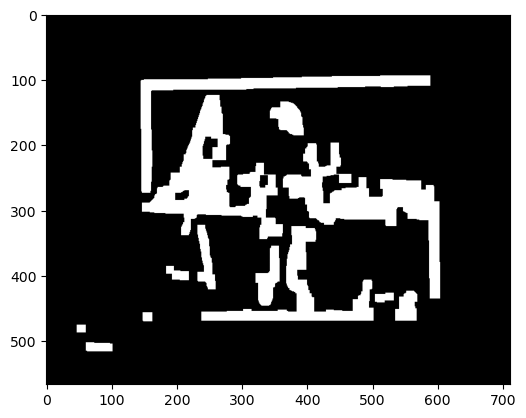

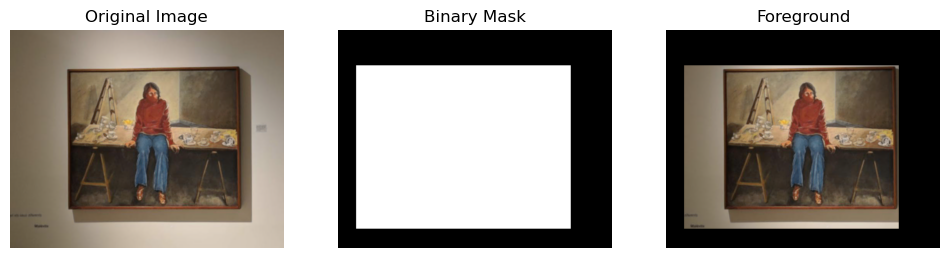

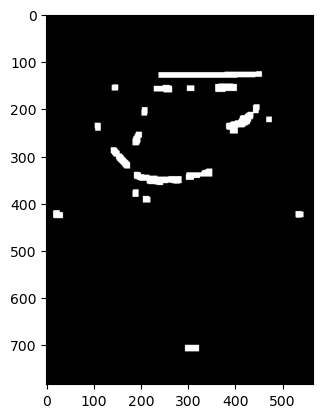

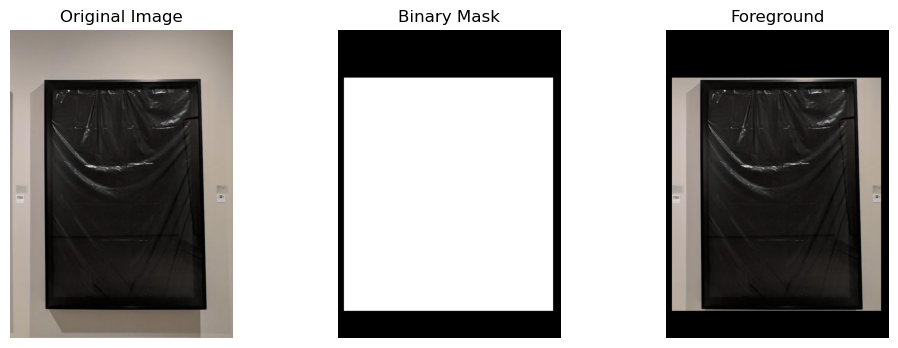

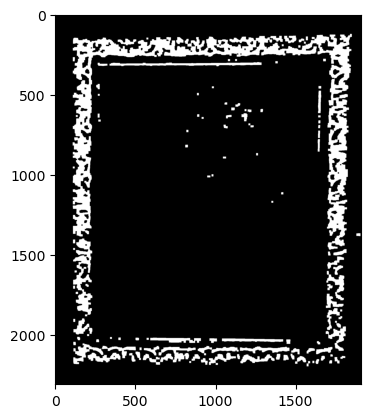

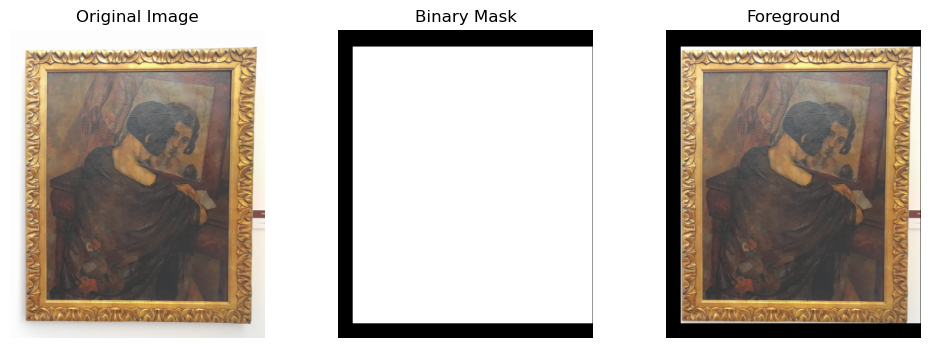

KeyboardInterrupt: 

In [43]:
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    original_image, mask, foreground = remove_background_morphological_gradient(image_path, filter='median')
    
    # Display the results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Binary Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Foreground")
    plt.imshow(foreground)
    plt.axis('off')
    
    plt.show()

In [ ]:
# Process each image
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    original_image, mask, foreground = remove_background(image_path, filter='median')
    
    # Display the results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Binary Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Foreground")
    plt.imshow(foreground)
    plt.axis('off')
    
    plt.show()